# Visualizing what convnets learn
***

## Visualizing intermediate activations 


### Import model

In [13]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Preprocess and display the target image

(1, 150, 150, 3)


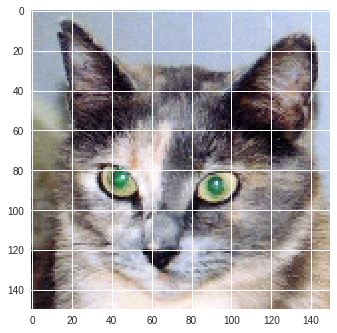

In [14]:
img_path = '/content/test_dir/cats_test/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

## Displaying intermediate activations using Model()

In [0]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

### Running the model in predict mode

In [0]:
activations = activation_model.predict(img_tensor)

### First layer activations

(1, 148, 148, 32)


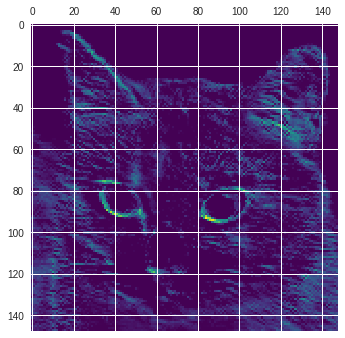

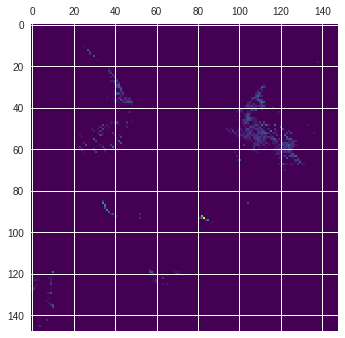

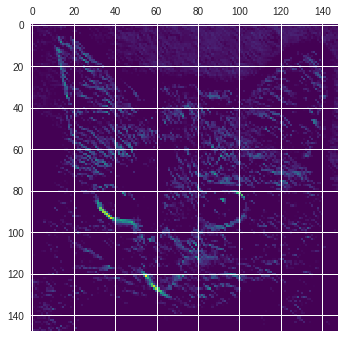

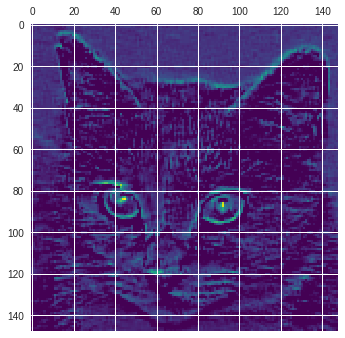

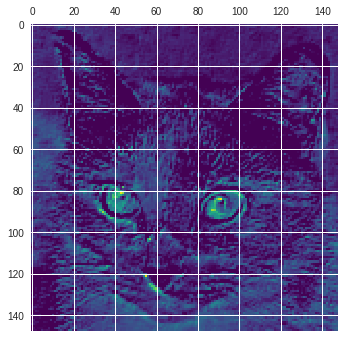

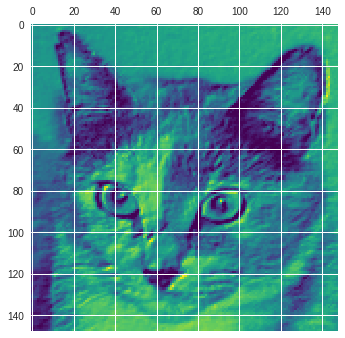

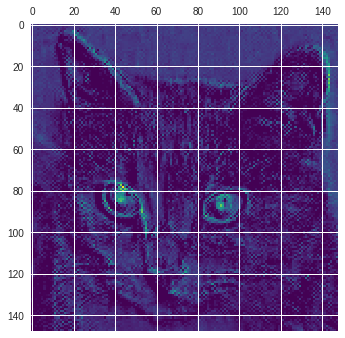

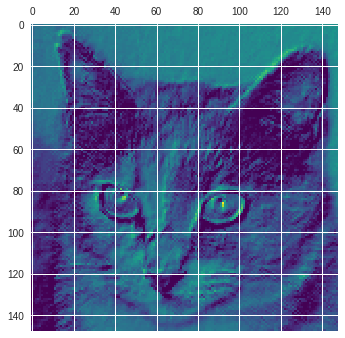

In [23]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

for i in range(8):
  plt.figure(i)
  plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

## Visualising every channel in every intermediate activations

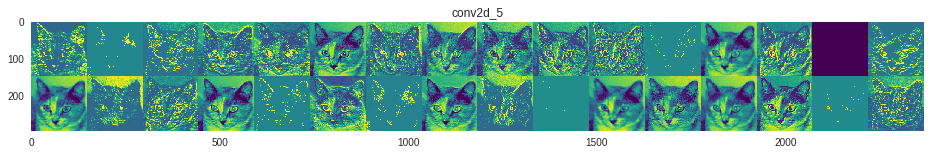

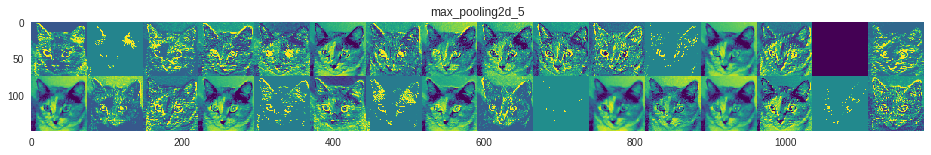

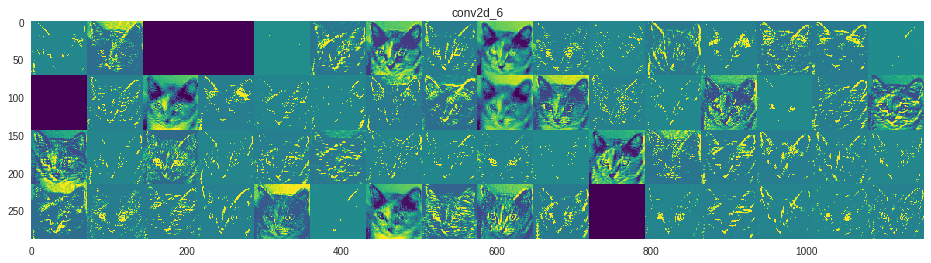

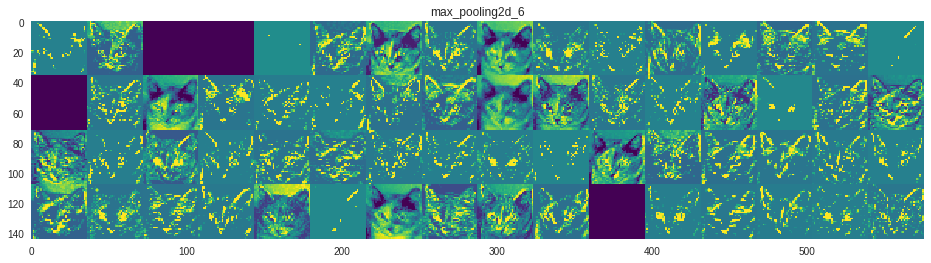

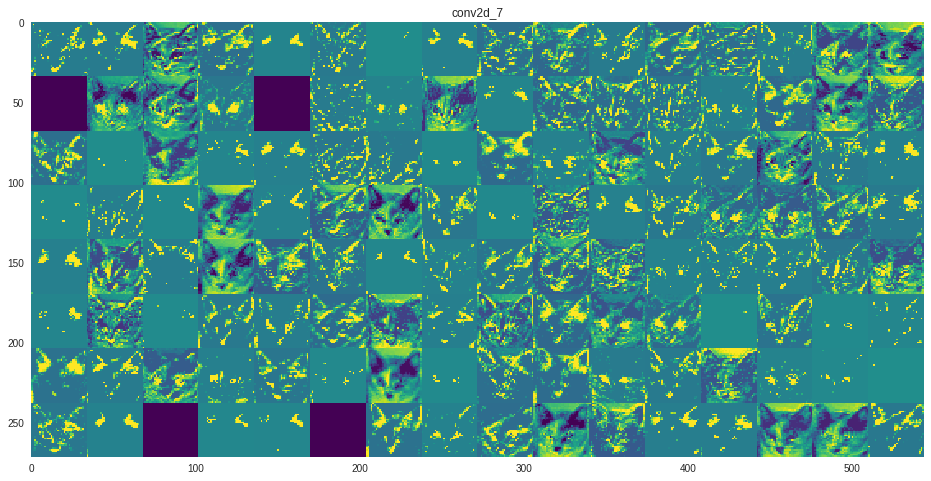

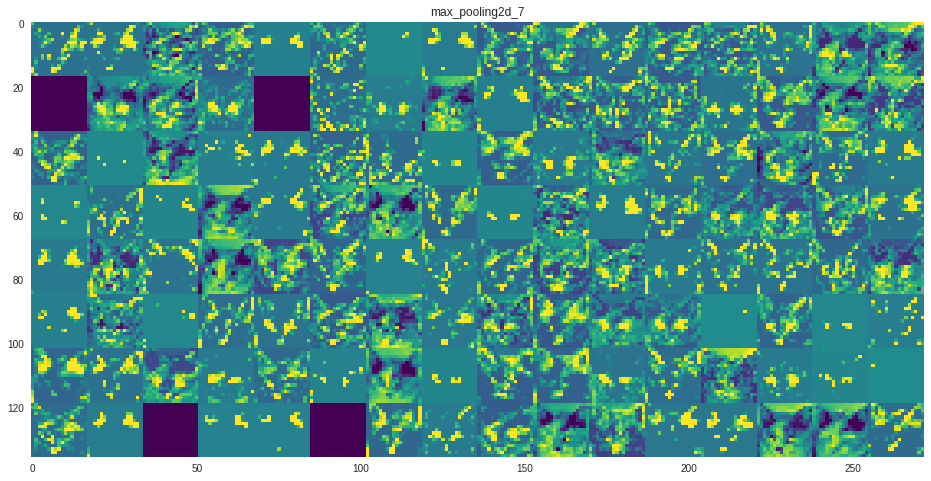

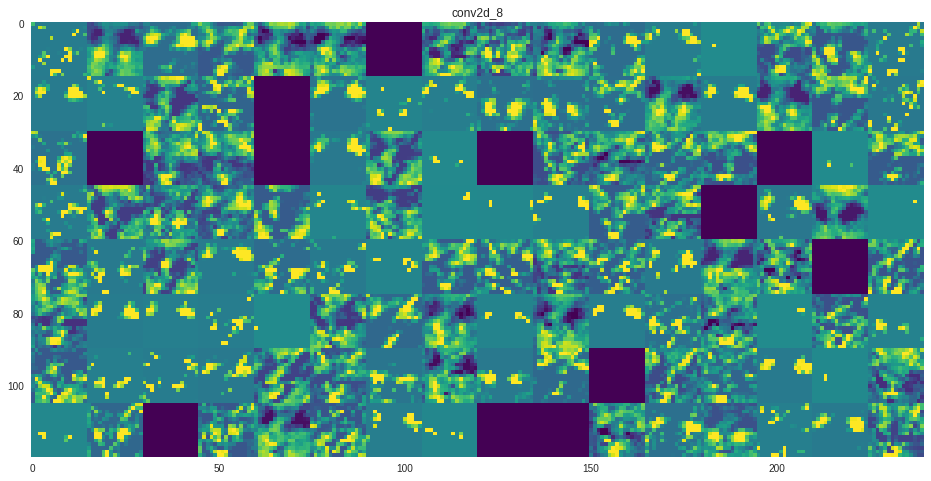

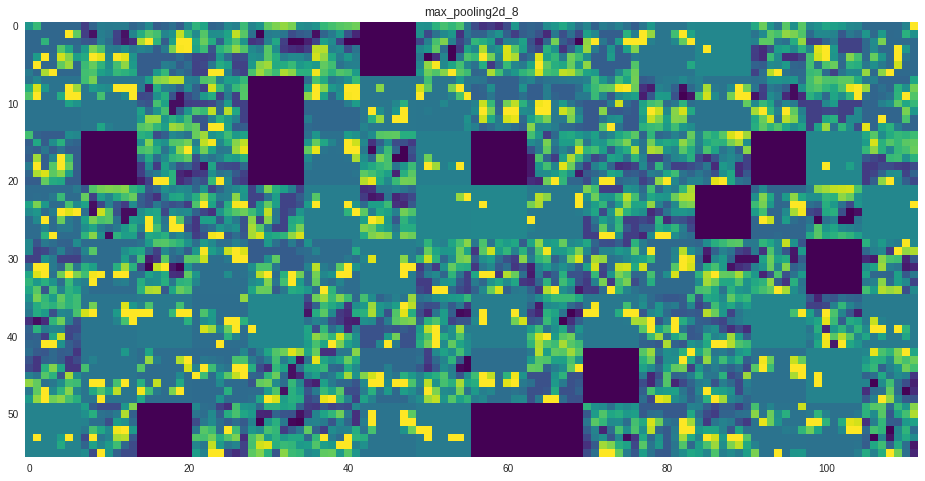

In [30]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)
  
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  
  size = layer_activation.shape[1]
  
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,
                                       :,:,
                                       col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_image
  scale = 1./size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Visualizing convnet filter

>> ### 1. Build a loss function that maximizes the value of a given filter in a given convolution layer.
>> ### 2. Use stochastic gradient descent to adjust the values of the input values so as to maximize this activation value.

In [0]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights = 'imagenet',
             include_top = False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# Obtaining the gradient of the loss with regard to the input

grads = K.gradients(loss, model.input)[0] # Computes the gradients based on model input

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Normalization to speed up the GD

iterate = K.function([model.input], [loss, grads]) 

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
# Loss maximization using stochastic gradient descent

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  
  input_img_data += grads_value * step

In [0]:
# Utility function to convert a tensor into a valid image

def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  
  x += 0.5
  x = np.clip(x, 0, 1)
  
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x
  

In [0]:
# Function to generate filter visualization

def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])

  # Obtaining the gradient of the loss with regard to the input

  grads = K.gradients(loss, model.input)[0] # Computes the gradients based on model input

  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Normalization to speed up the GD

  iterate = K.function([model.input], [loss, grads]) 

  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

  step = 1
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  
  img = input_img_data[0]
  return deprocess_image(img)


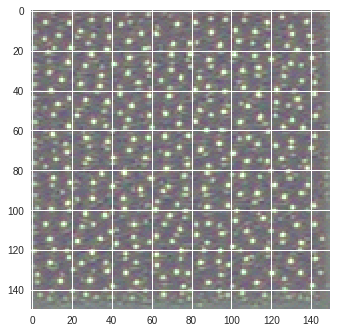

In [36]:
plt.imshow(generate_pattern('block3_conv1', 0))

### Generating a grid of all filter response patterns in a layer

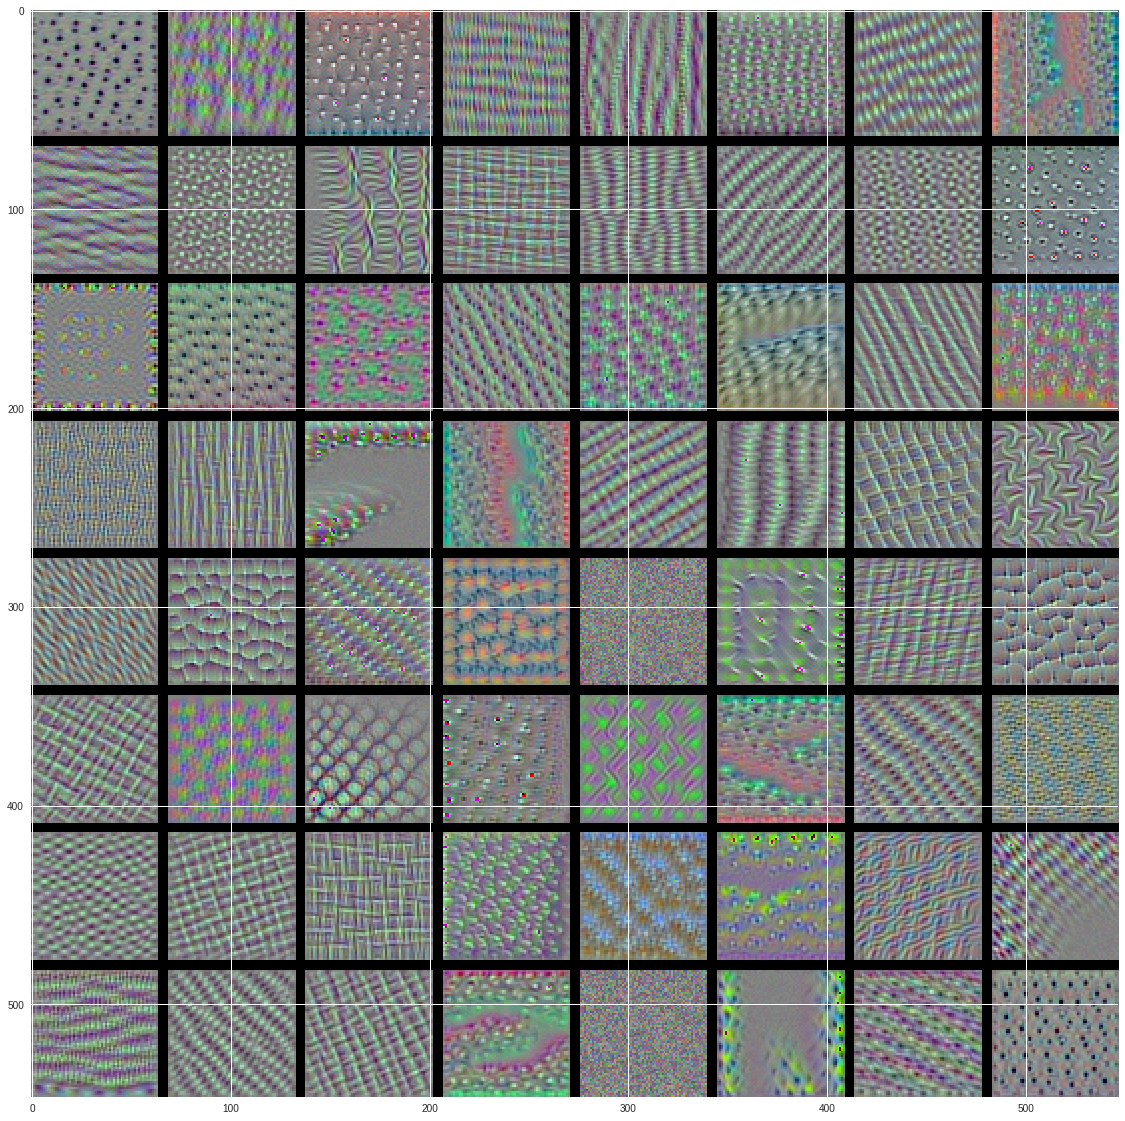

In [42]:
layer_name = 'block3_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
    
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start : horizontal_end,
           vertical_start : vertical_end, :] = filter_img
    
plt.figure(figsize=(20, 20))
plt.imshow(results)

## Visualizing heatmaps of class activation
***

>> ### 1. Allows to learn which parts of the image led a convnet to its final classification
>> ### 2. This general category of techniques is called class activation map (CAM) visualization

In [43]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 7s 0us/step


In [49]:
!ls '/content/drive/My Drive/deep_learning/'

AlexNet.py		  creative_common_elephant.jpg	keras_pg_68.ipynb
cats_and_dogs_small_2.h5  kaggle.json			VGGNet.py


### Preprocessing an input image for VGG16

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/My Drive/deep_learning/creative_common_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

### Get prediction

In [53]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01871265', 'tusker', 0.65107125), ('n02504458', 'African_elephant', 0.17711113), ('n02504013', 'Indian_elephant', 0.17178448)]


### Setting up Grad-CAM

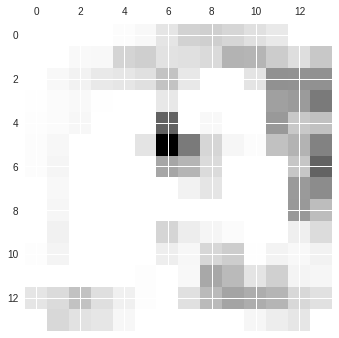

In [56]:
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [58]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/content/elephant_cam.jpg', superimposed_img)

True

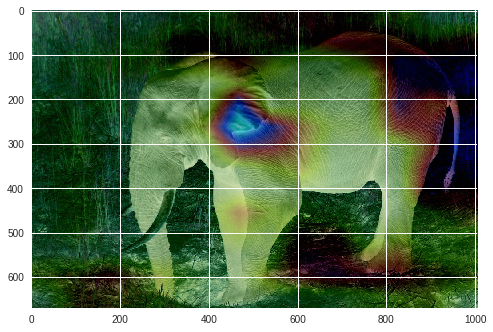

In [62]:
img = image.load_img('/content/elephant_cam.jpg')
img_arr = image.img_to_array(img)

plt.imshow(img_arr, cmap='viridis')